In [1]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import pandas as pd
import glob
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy
from sklearn.decomposition import PCA

from preprocessing import preprocess
from gating import *
from visualization.aux_dicts import *

from matplotlib import rc 

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}')


In [2]:
def get_feature_activations(norm, sparsity, percentile, X, x_train):
   
    meta = {'gumbel_temp': 1, 'gumbel_noise': 1e-8}
    model = MaskingModel(n_groups=x_train.shape[-1])

    filename = 'annealing_fg_'+norm+'_norm_'+str(sparsity)+'_perc_'+str(percentile)
    model.load_weights(MODEL_PATH + filename).expect_partial()

    masks = model.get_mask(X, meta)

    f_activated = tf.reduce_sum(masks, axis=0)
    f_activations = [(feature_names[i], f_activated[i].numpy()) for i in tf.where(f_activated)[:, 0]]
    
    return f_activations, masks

def get_cluster_features(labels, masks, feature_names, X, Y):
    
    clusters = {}
    for c in range(np.max(labels)+1):
        cluster = np.where(labels == c)[0]
        clusters[c] = {}
        clusters[c]['total_number_students'] = len(cluster)
        
        y_cluster = tf.gather(Y, list(cluster)).numpy()
        clusters[c]['total_number_pass_students'] = (y_cluster == 0).sum()
        clusters[c]['total_number_fail_students'] = (y_cluster == 1).sum()
        
        f_activated = tf.reduce_sum(tf.gather(masks, list(cluster)), axis=0)
        
        clusters[c]['features'] = {}
        for i in tf.where(f_activated)[:, 0]:
            # Select the indices that belong to the actual cluster and have feature 'i' activated
            a = np.where(masks[:, i] == 1)[0]
            a = list(set(a) & set(list(cluster))) 
            
            # Split the selected indices between pass/fail students
            target_0 = [j for j in a if Y[j] == 0]
            target_1 = [j for j in a if Y[j] == 1]
            
            clusters[c]['features'][feature_names[i]] = {}
            clusters[c]['features'][feature_names[i]]['number_students'] = f_activated[i].numpy()
            clusters[c]['features'][feature_names[i]]['avg_value'] = tf.reduce_mean(X[a, :, i]).numpy()
            clusters[c]['features'][feature_names[i]]['relative_value'] = tf.reduce_mean(X[a, :, i]).numpy()-tf.reduce_mean(X[:, :, i]).numpy()
            
            clusters[c]['features'][feature_names[i]]['number_pass_students'] = len(target_0)
            clusters[c]['features'][feature_names[i]]['avg_pass_value'] = tf.reduce_mean(X[target_0, :, i]).numpy()
            clusters[c]['features'][feature_names[i]]['relative_pass_value'] = tf.reduce_mean(X[target_0, :, i]).numpy()-tf.reduce_mean(X[:, :, i]).numpy()
            clusters[c]['features'][feature_names[i]]['number_fail_students'] = len(target_1)
            clusters[c]['features'][feature_names[i]]['avg_fail_value'] = tf.reduce_mean(X[target_1, :, i]).numpy()
            clusters[c]['features'][feature_names[i]]['relative_fail_value'] = tf.reduce_mean(X[target_1, :, i]).numpy()-tf.reduce_mean(X[:, :, i]).numpy()
            
    return clusters

The code below creates a table with all the information about clustering and the selected features for all configurations of normalization and sparsity targets tested using the first 4 weeks of each course.

In [ ]:
percentile = 0.4
data_path = '../data/'
feature_types = ['lalle_conati', 'boroujeni_et_al', 'chen_cui', 'marras_et_al']
metadata = pd.read_csv(data_path + 'metadata.csv')
df = {}
df['course'] = []
df['number_students'] = []
df['norm'] = []
df['sparsity'] = []
df['max_features'] = []
df['average_features'] = []
df['features_for_all_students'] = []
df['train_bal_acc'] = []
df['val_bal_acc'] = []
df['test_bal_acc'] = []
df['f_activations'] = []
df['number_clusters'] = []
df['silhouette_score'] = []
df['clusters_labels'] = []
df['clusters_dict'] = []

for course in courses:
    results_path = '../results/' + course + '/inter-c3/'
    MODEL_PATH = '../models/saved/' + course + '/'
    path = data_path + course + '/'
    print(course)
    
    try:
        clusters = pd.read_pickle(results_path+'clusters_info.pkl')  
        
    except:
        continue
    
    norm_sparsity = {}
    norm_sparsity['unit'] = []
    norm_sparsity['min-max'] = []
    for f in glob.glob(MODEL_PATH+'*.index'):
        f = f.replace(MODEL_PATH, '').replace('.index', '').replace('annealing_fg_', '')
        f = f.split('_')
        if f[0] == 'unit' or f[0] == 'min-max':
            norm_sparsity[f[0]].append(float(f[2]))
    
    norm_sparsity['unit'].sort()
    norm_sparsity['min-max'].sort()
    
    for norm in norm_sparsity.keys():
        x_train, x_test, x_val, y_train, y_test, y_val, feature_names = preprocess(course, path, percentile, 
                                                                                   feature_types, metadata, 
                                                                                   normalization=norm)
        X = np.concatenate([x_train, x_val, x_test], axis=0)
        Y = np.concatenate([y_train, y_val, y_test], axis=0)
        
        clusters_per_norm = clusters[clusters['norm'] == norm]
        for sparsity in np.unique(norm_sparsity[norm]):
            
            clusters_per_sparsity = clusters_per_norm[clusters_per_norm['sparsity'] == sparsity]
            if len(clusters_per_sparsity) == 0:
                continue
                
            clusters_per_sparsity = clusters_per_sparsity.reset_index()
            
            f_activations, masks = get_feature_activations(norm, sparsity, percentile, X, x_train)
            
            df['course'].append(course)
            df['number_students'].append(X.shape[0])
            df['norm'].append(norm)
            df['sparsity'].append(sparsity)
            df['max_features'].append(len(f_activations))
            df['average_features'].append(np.mean(tf.reduce_sum(masks, axis=1).numpy()))
            count = 0
            for f, a in f_activations:
                if a/X.shape[0] == 1:
                    count += 1
            df['features_for_all_students'].append(count)
            
            try: 
                scores = np.load(results_path+'scores_'+norm+'_norm_'+str(sparsity)+'.npy',allow_pickle='TRUE').item()
            except:
                scores = np.load(results_path+'scores_'+norm+'_norm_'+str(sparsity)+'_perc_'+str(percentile)+'.npy',allow_pickle='TRUE').item()
            df['train_bal_acc'].append(scores['train_bal_acc'][-1].numpy())
            df['val_bal_acc'].append(scores['val_bal_acc'][-1].numpy())
            
            test_acc = np.load(results_path+'test_acc_'+norm+'_norm_'+str(sparsity)+'.npy',allow_pickle='TRUE').item()
            df['test_bal_acc'].append(test_acc)
            
            df['f_activations'].append(f_activations)
            df['number_clusters'].append(clusters_per_sparsity['number_clusters'].tolist()[0])
            df['silhouette_score'].append(clusters_per_sparsity['silhouette_score'].tolist()[0])
            df['clusters_labels'].append(clusters_per_sparsity['labels'][0])

            df['clusters_dict'].append(get_cluster_features(clusters_per_sparsity['labels'][0], masks, 
                                                    feature_names, X, Y))
            


In [ ]:
df = pd.DataFrame(df)
pd.to_pickle(df, '../results/final_results.pkl') 

In [3]:
df = pd.read_pickle('../results/final_results.pkl')

In [4]:
best_unit = {}
best_unit['analysenumerique_002'] = 0.58
best_unit['analysenumerique_003'] = 0.58
best_unit['cpp_fr_001'] = 0.6
best_unit['dsp_001'] = 0.5
best_unit['dsp_002'] = 0.5
best_unit['dsp_004'] = 0.56
best_unit['dsp_005'] = 0.5
best_unit['dsp_006'] = 0.55
best_unit['geomatique_003'] = 0.6
best_unit['hwts_001'] = 0.5
best_unit['hwts_002'] = 0.6
best_unit['initprogcpp_001'] = 0.6
best_unit['microcontroleurs_003'] = 0.6
best_unit['microcontroleurs_004'] = 0.5
best_unit['microcontroleurs_005'] = 0.55
best_unit['microcontroleurs_006'] = 0.55
best_unit['progfun_002'] = 0.5
best_unit['venture_001'] = 0.55
best_unit['villesafricaines_001'] = 0.5
best_unit['villesafricaines_002'] = 0.5
best_unit['villesafricaines_003'] = 0.5

In [5]:
# Best sparsity criteria for min-max norm:

# best = {}
# best['analysenumerique_002'] = 0.54
# best['analysenumerique_003'] = 0.57 
# best['cpp_fr_001'] = 0.6
# best['dsp_001'] = 0.43
# best['dsp_002'] = 0.5
# best['dsp_004'] = 0.5
# best['dsp_005'] = 0.5
# best['dsp_006'] = 0.5
# best['geomatique_003'] = 0.6
# best['hwts_001'] = 0.55
# best['hwts_002'] = 0.54
# best['initprogcpp_001'] = 0.58
# best['microcontroleurs_003'] = 0.56
# best['microcontroleurs_004'] = 0.45
# best['microcontroleurs_005'] = 0.5
# best['microcontroleurs_006'] = 0.55
# best['progfun_002'] = 0.45
# best['venture_001'] = 0.55
# best['villesafricaines_001'] = 0.5
# best['villesafricaines_002'] = 0.5
# best['villesafricaines_003'] = 0.5

In [7]:
df_selected = pd.DataFrame()
for i, (course, sparsity) in enumerate(zip(best_unit, best_unit.values())):
    c = df[df['course'] == course]
    c = c[c['norm'] == 'unit']
    c = c[c['sparsity'] == sparsity]

    c = c.reset_index()
    df_selected = pd.concat([df_selected, c])

In [8]:
def get_cluster_with_more_fail(x):
    proportion_fail = 0 
    idx_cluster = -1
        
    for cluster in x.keys():
        p = x[cluster]['total_number_fail_students']/x[cluster]['total_number_pass_students']
        
        if p > proportion_fail:
            proportion_fail = p
            idx_cluster = cluster
            
    return idx_cluster

def get_cluster_with_more_pass(x):
    proportion_pass = 0
    idx_cluster = -1
        
    for cluster in x.keys():
        p = x[cluster]['total_number_pass_students']/x[cluster]['total_number_fail_students']
        
        if p > proportion_pass:
            proportion_pass = p
            idx_cluster = cluster
            
    return idx_cluster

def get_cluster_more_balanced(x):
    diff = sys.maxsize
    idx_cluster = -1
        
    for cluster in x.keys():
        p = x[cluster]['total_number_pass_students'] - x[cluster]['total_number_fail_students']
        
        if np.abs(p) < diff :
            diff = np.abs(p)
            idx_cluster = cluster
            
    return idx_cluster
            
def get_feature_importance_df(cluster_type):
    df_importance = pd.DataFrame()
    features_per_cluster = {}
    i = 0
    save_cluster = []
    for course in df_selected['course']:
        x = df_selected[df_selected['course'] == course]
        x = x['clusters_dict'][0]
        
        if cluster_type == 'fail':
            idx_cluster = get_cluster_with_more_fail(x)
        elif cluster_type == 'pass':
            idx_cluster = get_cluster_with_more_pass(x)
        elif cluster_type == 'balanced':
            idx_cluster = get_cluster_more_balanced(x)
        
        feature_importance = {}
        save_cluster.append(idx_cluster)
        n = x[idx_cluster]['total_number_students']
        for f in x[idx_cluster]['features'].keys():
            feature_importance[f] = x[idx_cluster]['features'][f]['number_students']/n
        aux = pd.DataFrame(feature_importance, index=[i])
        df_importance = pd.concat([df_importance, aux])
        i += 1
    
    return df_importance, save_cluster

df_balanced, clusters_balanced = get_feature_importance_df('balanced')
df_fail, clusters_fail = get_feature_importance_df('fail')
df_pass, clusters_pass = get_feature_importance_df('pass')

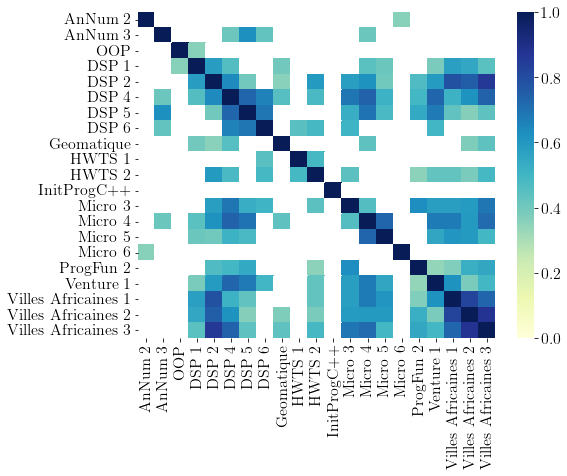

In [10]:
def get_spearmans_plot(df_importance, labels, f_name):
    df_importance = df_importance.fillna(0)
    
    zero_data = np.zeros(shape=(len(df_importance), len(df_importance)))
    cols = labels
    d = pd.DataFrame(zero_data, columns=cols)
    p = pd.DataFrame(zero_data, columns=cols)

    data = []
    for i in range(len(df_importance)):
        data.append(df_importance.iloc[i])

    count = 0
    for i in range(len(d)):
        for k,j in enumerate(d.columns):
            d[j][i] = stats.spearmanr(data[i], data[k])[0]
            if stats.spearmanr(data[i], data[k])[1] > 0.05:
                d[j][i] = -1
            
    
    my_cmap = copy(plt.cm.YlGnBu)
    my_cmap.set_over("white")
    my_cmap.set_under("white")
    
    fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
    g = sns.heatmap(d, vmin=0, fmt=".2f",ax=ax, cmap=my_cmap)
    l=list(np.arange(1,6+1))
    g.xaxis.get_label().set_fontsize(16)
    g.yaxis.get_label().set_fontsize(16)
    g.set_xticklabels(labels,rotation=90, fontsize=16)
    g.set_yticklabels(labels, rotation=0, fontsize=16)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    
    plt.savefig(f_name, bbox_inches='tight')
    plt.show()
    
    return d

d_fail = get_spearmans_plot(df_fail, [dict_course_names[i] for i in best_unit.keys()], "../images/unit/over_all_worst.jpeg")

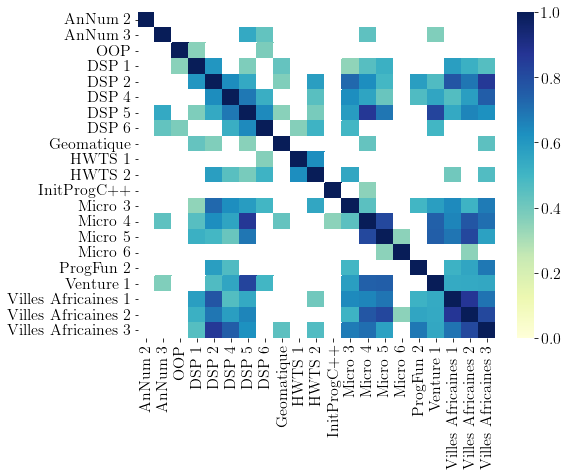

In [11]:
d_pass = get_spearmans_plot(df_pass, [dict_course_names[i] for i in best_unit.keys()],  "../images/unit/over_all_best.jpeg")

In [12]:
for i in range(len(d_fail)):
    for k,j in enumerate(d_fail.columns):
        if d_fail[j][i] == -1:
            d_fail[j][i] = 0

In [13]:
for i in range(len(d_pass)):
    for k,j in enumerate(d_pass.columns):
        if d_pass[j][i] == -1:
            d_pass[j][i] = 0

In [14]:
cols = [dict_course_names[i] for i in best_unit.keys()]

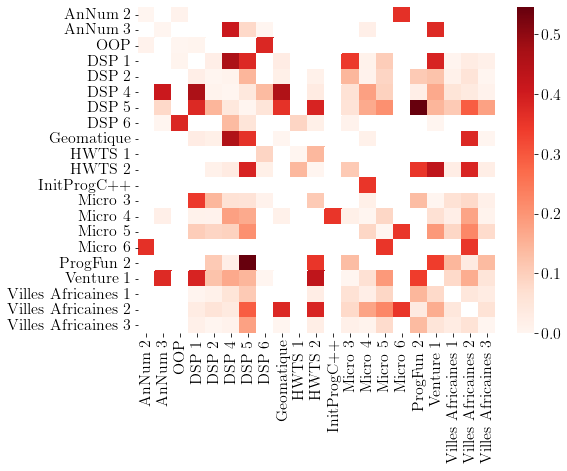

In [15]:
zero_data = np.zeros(shape=(21, 21))
d = pd.DataFrame(zero_data, columns=cols)

for i in range(len(d_pass)):
    for k,j in enumerate(d_pass.columns):
        d[j][i] = np.abs(d_pass[j][i]-d_fail[j][i])
        if d[j][i] == 0:
            d[j][i] = -1

my_cmap = copy(plt.cm.Reds)
my_cmap.set_over("white")
my_cmap.set_under("white")

fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d, vmin=0, fmt=".2f",ax=ax, cmap=my_cmap)
l=list(np.arange(1,6+1))
g.xaxis.get_label().set_fontsize(14)
g.yaxis.get_label().set_fontsize(14)
g.set_xticklabels(cols,rotation=90, fontsize=16)
g.set_yticklabels(cols, rotation=0, fontsize=16)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)

plt.savefig("../images/unit/over_all_diff.jpeg", bbox_inches='tight')
plt.show()

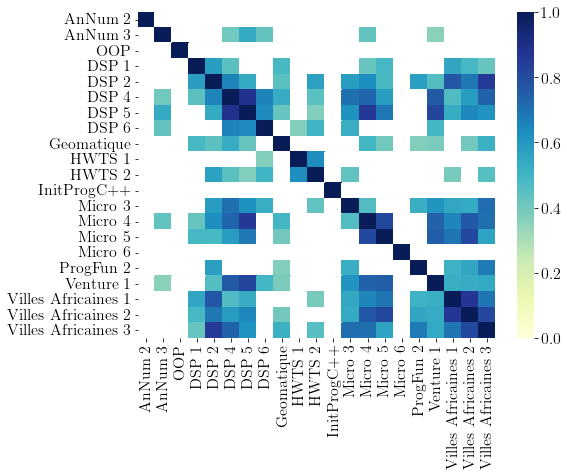

In [16]:
d_balanced = get_spearmans_plot(df_balanced, [dict_course_names[i] for i in best_unit.keys()], "../images/unit/over_all_balanced.pdf")

In [18]:
def plot_metadata(funct, df, fname):
    labels_in_order = []
    for c in best_unit.keys():
        labels_in_order.append(funct[c])
    
    df['labels'] = labels_in_order
    df = df.fillna(0)
    
    x = df.groupby('labels').mean().reset_index()
    
    labels = x['labels']

    x = x.drop('labels', axis=1)

    get_spearmans_plot(x, labels.tolist(), fname)
    
    return x

In [19]:
def sub_analyses_plots(df, type_):
    topics_df = plot_metadata(topics_course, df, "../images/unit/"+type_+"_topics_heatmap.jpeg")
    quizzes_df = plot_metadata(no_quizzes_course, df, "../images/unit/"+type_+"_n_quizzes_heatmap.jpeg")
    language_level_df = plot_metadata(language_and_level_course, df, "../images/unit/"+type_+"_lang_level_heatmap.jpeg")
    weeks_df = plot_metadata(no_weeks_course, df, "../images/unit/"+type_+"_n_weeks_heatmap.jpeg")
    return topics_df, quizzes_df, language_level_df
    

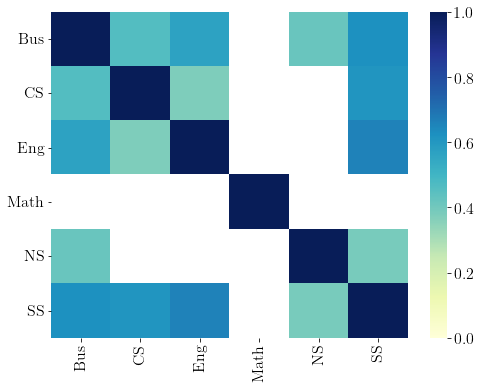

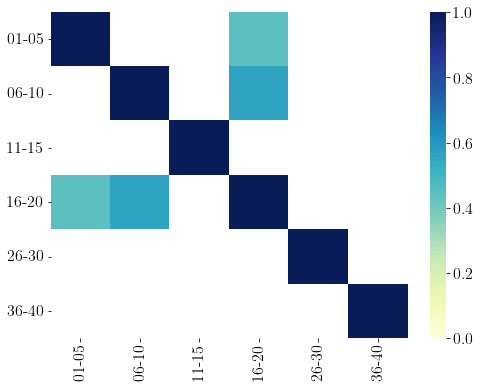

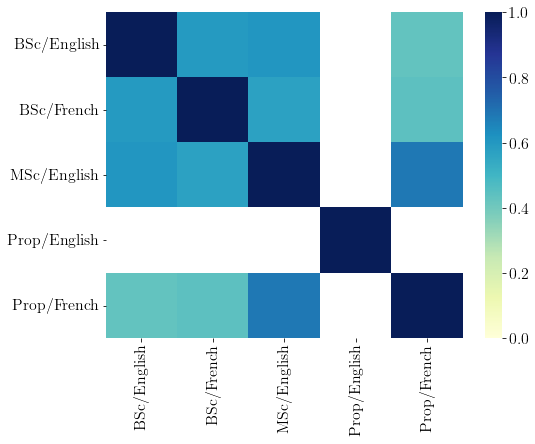

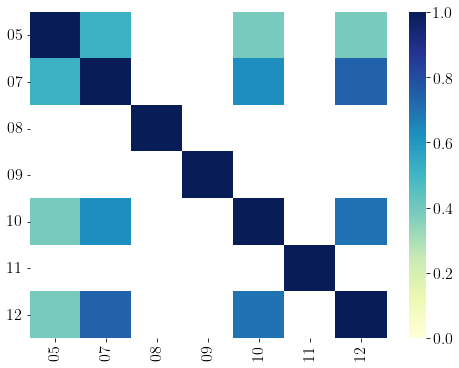

In [20]:
topics_df, quizzes_df, language_level_df = sub_analyses_plots(df_fail, 'worst')

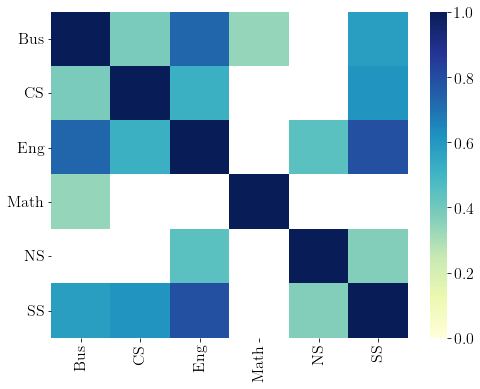

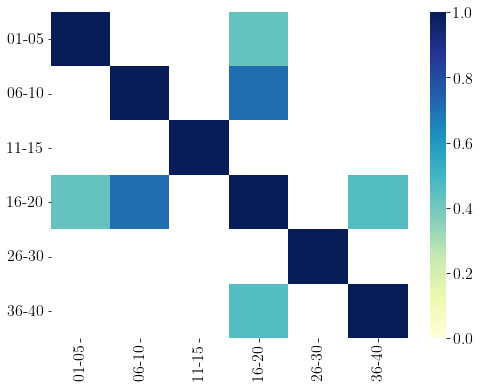

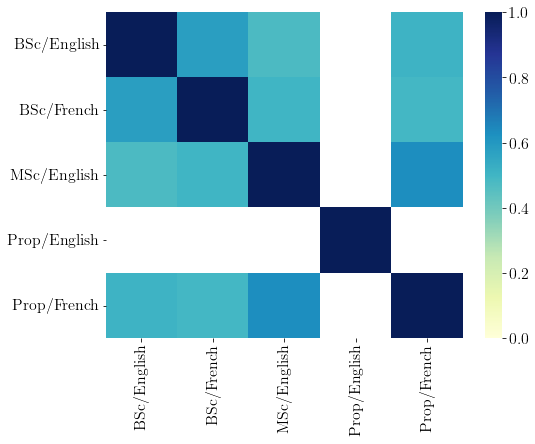

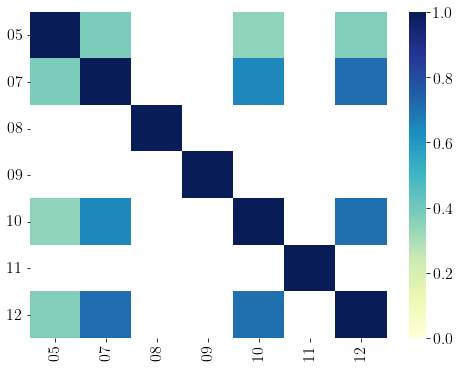

In [21]:
topics_df2, quizzes_df, language_level_df = sub_analyses_plots(df_pass, 'best')

In [22]:
labels_in_order = []
for c in best_unit.keys():
    labels_in_order.append(topics_course[c])

In [23]:
df_fail = df_fail.drop('labels', axis=1)

In [24]:
df_fail = df_fail.fillna(0)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


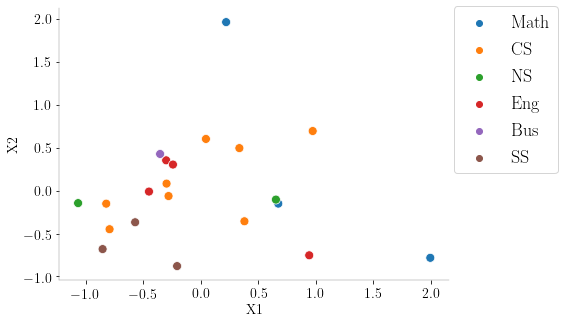

In [25]:
pca2 = PCA(n_components=2)
PCA2 = pca2.fit_transform(df_fail)
dfpca = pd.DataFrame(PCA2)
dfpca['cluster'] = labels_in_order
dfpca.columns = ['x1','x2','cluster']
    
plt.figure(figsize=(7,5))
sns.scatterplot(data=dfpca,x='x1',y='x2',hue='cluster',legend="full",alpha=1, s=80)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.04), fontsize=18)
plt.tick_params(labelsize=14)
plt.ylabel('X2',fontsize=14)
plt.xlabel('X1',fontsize=14)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

plt.gca().spines['left'].set_linewidth(0.4)
plt.gca().spines['bottom'].set_linewidth(0.4)

plt.gca().spines['left'].set_color('grey')
plt.gca().spines['bottom'].set_color('grey')

plt.savefig("../images/unit/pca_worst.pdf", bbox_inches='tight')
plt.show()

In [ ]:
df_pass = df_pass.drop('labels', axis=1)
df_pass = df_pass.fillna(0)

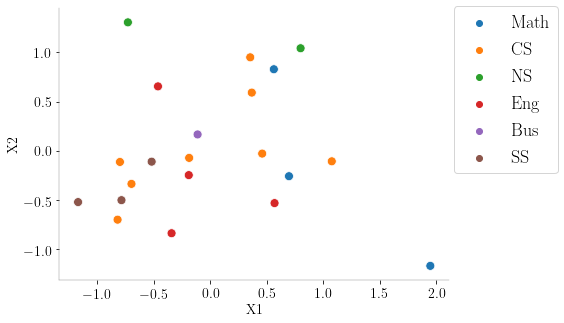

In [27]:
pca2 = PCA(n_components=2)
PCA2 = pca2.fit_transform(df_pass)
dfpca = pd.DataFrame(PCA2)
dfpca['cluster'] = labels_in_order
dfpca.columns = ['x1','x2','cluster']
    
plt.figure(figsize=(7,5))
sns.scatterplot(data=dfpca,x='x1',y='x2',hue='cluster',legend="full",alpha=1, s=80)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.04), fontsize=18)
plt.tick_params(labelsize=14)
plt.ylabel('X2',fontsize=14)
plt.xlabel('X1',fontsize=14)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)

plt.gca().spines['left'].set_linewidth(0.4)
plt.gca().spines['bottom'].set_linewidth(0.4)

plt.gca().spines['left'].set_color('grey')
plt.gca().spines['bottom'].set_color('grey')

plt.savefig("../images/unit/pca_best.pdf", bbox_inches='tight')
plt.show()